# A simple elastic behaviour

## `MFront` implementation

To give a first introduction to writing material behaviors using `MFront`, we will implement a very simple linear elastic model :

$$
\tens{\sigma} = \lambda\:\mathrm{tr}(\tens{\varepsilon})\tens{I}+2\mu\tens{\varepsilon},
$$

where $\lambda$ and $\mu$ are the Lamé coefficients.
The parameters of the model will be Young's modulus $E$ and Poisson's ration $\nu$, while the output will be the Cauchy stress tensor $\tens{\sigma}$.
Of course, we could use one of `Mfront`'s standard `brick` for this purpose, but the idea here is to define everything ourselves.

Here is a look at the corresponding `elasticity.mfront` file:

```cpp
@DSL DefaultGenericBehaviour;
@Author Maxime Pierre;
@Date 22/11/2025;

@Behaviour Elasticity;
```

First, we specify the _domain specific language_ (DSL) that we want to use.
It will condition what `keywords` we will have access to in the rest of the file.
After optionally declaring an `author` and a `date`, we give a name to our behaviour (`Elasticity`).


Next, we define the input and output variables of our model : the strain tensor $\tens{\varepsilon}$ (a `gradient` of the displacement), and its associated `flux` which is the stress tensor $\tens{\sigma}$.

```cpp
@Gradient StrainStensor εᵗᵒ;
εᵗᵒ.setGlossaryName("Strain");

@Flux StressStensor σ;
σ.setGlossaryName("Stress");
```

Then, we define the material properties which must be passed to the behaviour:

```cpp
@MaterialProperty stress E;
E.setGlossaryName("YoungModulus");

@MaterialProperty real ν;
ν.setGlossaryName("PoissonRatio");
```
:::{note} Naming variables in `MFront`
:class: dropdown
:open: true
Note that all the names of variables and properties used so far are very common, and part of the standard `glossary` of `MFront`. They are therefore applied using the `setGlossaryName` method. For names which are not part of the glossary, any name can be applied using the `setEntryName` method instead.
:::

Now, we define the blocks composing the *tangent operator*.
In our simple case, their is only one, $\partial\tens{\sigma}/\partial\tens{\varepsilon}$, which corresponds to the stiffness tensor $\mathbb{C}$.

```cpp
@TangentOperatorBlocks{∂σ∕∂Δεᵗᵒ};
@ProvidesTangentOperator ;
```

Finally, we enter the core of the behaviour with the `Integrator` block.
This is where the behaviour of the material is actually calculated.
`MFront` provides some helper functions to calculate Lamé's coefficients from $E$ and $\nu$.
Then, we calculate the stress with an incremental formulation (note that in the case of elasticity, a total formulation would also have been acceptable).
The last part gives the one tangent operator block that was declared above.

```cpp
@Integrator{
  const auto λ = computeLambda(E, ν);
  const auto μ = computeMu(E, ν);
  σ += λ ⋅ trace(Δεᵗᵒ) ⋅ I₂ + 2 ⋅ μ ⋅ Δεᵗᵒ ;

  if (computeTangentOperator_) {
    ∂σ∕∂Δεᵗᵒ = λ ⋅ (I₂ ⊗ I₂) + 2 ⋅ μ ⋅ I₄;
  }
}
```


## Compiling a behaviour

Once the `.mfront` file is written, we need to compile it to create a shared library that can then be used in other contexts (`mtest`, `python`, `FEniCS`...).
This can be done from the terminal using the following command:

```bash
mfront --obuild --interface=generic elasticity.mfront
```

Here, we used the `generic` interface, which is the one used to plug the constitutive laws into `python` or `FEniCS` using `MGIS`, the `MFront` Generic Interface Support.
The command creates or updates a shared library `src/libBehaviour.so` on Linux or `src/libBehaviour.dylib` on MacOS (note the difference in extension for dynamic libraries).

## Testing the behaviour with `mtest`

```cpp
@Behaviour<Generic> 'src/libBehaviour.dylib' 'PoroElasticity';
@MaterialProperty<constant> 'YoungModulus' 1e+10 ;
@MaterialProperty<constant> 'PoissonRatio' 0.2 ;
```

## Interacting with the behaviour in `python`

Using the `mtest` package in `python`, it is possible to interact with a compiled `MFront` behaviour.

First, we have to set the behaviour for our test as well as the different material properties that are necessary.
We chose Young's Modulus as 10 MPa and Poisson's ration as 0.2.

In [47]:
from sys import platform
import std
import tfel.math
import numpy as np
from mtest import (
    MTest,
    VerboseLevel,
    PredictionPolicy,
    setVerboseMode,
    MTestCurrentState,
    MTestWorkSpace,
    Behaviour,
)

def lib_ext() -> str | None:
    if platform == "linux":
        return ".so"
    elif platform == "darwin":
        return ".dylib"

setVerboseMode(VerboseLevel.VERBOSE_LEVEL2)

In [48]:
test = MTest()
state = MTestCurrentState()
workspace = MTestWorkSpace()

# Setting the behaviour
behaviour = Behaviour("generic", f"../MFront_library/src/libBehaviour{lib_ext()}", "Elasticity","Tridimensional")
test.setBehaviour("generic", f"../MFront_library/src/libBehaviour{lib_ext()}", "Elasticity")

# Setting the material properties
test.setMaterialProperty("YoungModulus", 1e10)
test.setMaterialProperty("PoissonRatio", 0.2)

Next, we set the conditions for the test. The `setImposedGradient` method allows to control the different components of the gradients (here strain) by their name, and the `setImposedThermodynamicForce` method does the same for thermodynamic forces (here stress). A single value can be provided, or a dictionary with several entries to have a variation over time, similar to the `mtest` syntax.

We impose oedometric conditions on the sample: $x$ and $y$ deformation are prevented while we apply an axial load up the 10 MPa in compression.

In [49]:
test.setExternalStateVariable("Temperature", 293.15)
test.setImposedGradient("StrainXX", 0.0)
test.setImposedGradient("StrainYY", 0.0)
test.setImposedThermodynamicForce("StressZZ", {0.0: 0.0, 1.0: -1e7})

test.completeInitialisation()
test.initializeCurrentState(state)
test.initializeWorkSpace(workspace)

We perform a simulation with 10 steps between times 0 and 1, and store the results to show the stress-strain curve of the oedometric test.
Obviously, this is a very simple test and the results is a simple line with slope $E_\mathrm{oed}$.

In [50]:
t = np.linspace(0,1,10)
epszz_index = behaviour.getGradientComponentPosition("StrainZZ")
sigzz_index = behaviour.getThermodynamicForceComponentPosition("StressZZ")

epszz = [0.0]
sigzz = [0.0]

for i in range(len(t)-1):
    test.execute(state, workspace, t[i], t[i+1])
    epszz.append(-state.e1[epszz_index])
    sigzz.append(-state.s1[sigzz_index])

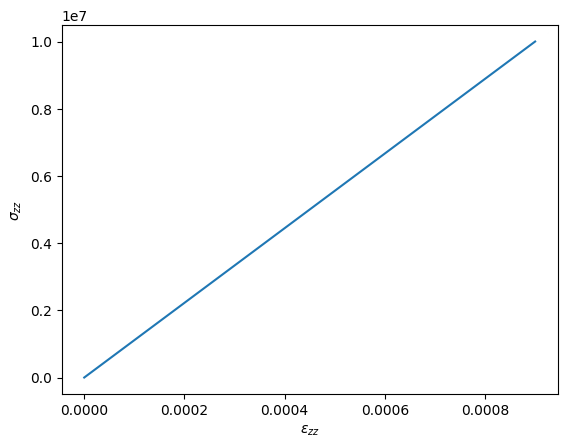

In [51]:
import matplotlib.pyplot as plt

plt.plot(epszz, sigzz)
plt.xlabel(r"$\varepsilon_{zz}$ [Pa]")
plt.ylabel(r"$\sigma_{zz}$ [-]")
plt.show()

We can compare the resulting oedometric modulus from the simulation with the analytical formula:

$$
E_\mathrm{oed} = \frac{E(1-\nu)}{(1+\nu)(1-2\nu)}.
$$

In [58]:
print(f"Modulus from simulation: {sigzz[-1]/epszz[-1]/1e9:.2f} GPa")
print(f"Analytical oedometric modulus: {1e10*(1-0.2)/(1+0.2)/(1-2*0.2)/1e9:.2f} GPa")

Modulus from simulation: 11.11 GPa
Analytical oedometric modulus: 11.11 GPa
